In [2]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin


class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

In [3]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # win_size = (12, 24, 48, 96, 192, 384, 768)
    win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

3 -12.339902740343334
5 -7.82648153103837
10 -2.6024677930599944
15 -1.333833590769434
20 -0.38111719913646214
25 -0.4507534984842647
30 -0.0200036636658818
40 -0.054729848734605735
50 -2.3246374179826
Rolling Mean best with win=30 -> R2=-0.0200036636658818


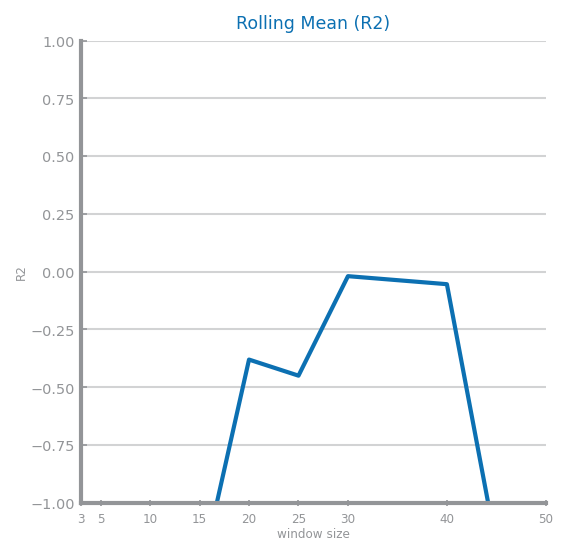

In [14]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series, HEIGHT

filename: str = "data/time_series/forecast_covid_single.csv"
file_tag: str = "Covid-19"
target: str = "deaths"
timecol: str = "date"
measure: str = "R2"

df: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df


df = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
df: DataFrame = scale_all_dataframe(df)
df = df.rolling(window = 25).mean()
df.dropna(inplace=True)
df = df.diff()
df = df.diff()
df.dropna(inplace=True)


series: Series = df[target]

train, test = series_train_test_split(df, trn_pct=0.90)

fig = figure(figsize=(HEIGHT, HEIGHT))
best_model, best_params = rolling_mean_study(train, test)
savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")